In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
from inference.inference_utils import choose_model 
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [ ]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)



loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [5]:
datamodule.setup("predict")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.predict_dataloader()

In [6]:
max_radius = fp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")
rankingset_data = rankingset_data.to(model.device)


/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [7]:
from rdkit.Chem import rdFingerprintGenerator

def gen_mfp(smiles):
    MFP_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    mol = Chem.MolFromSmiles(smiles)
    fp = MFP_generator.GetFingerprint(mol)
    return torch.tensor(fp).float()

def cos_sim_of_smiles(smiles1, smiles2):
    try:
        fp1 = gen_mfp(smiles1)
        fp2 = gen_mfp(smiles2)
        cos_sim = torch.nn.functional.cosine_similarity(fp1, fp2, dim=0)
        return cos_sim.item()
    except Exception as e:
        return 0

from torch.nn.functional import cosine_similarity
import tqdm

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plot_order = [
    'eHSQC, H NMR, and C NMR',
    'eHSQC and C NMR',
    'Standard HSQC, H NMR, and C NMR',
    'Standard HSQC and C NMR',
    'eHSQC and H NMR',
    'eHSQC Only',
    'Standard HSQC and H NMR',
    'Standard HSQC only',
    'C NMR and H NMR',
    'DeepSAT -- eHSQC',
    'DeepSAT -- Standard HSQC',
    'C NMR Only',
    'H NMR Only'
]
def show_retrievals_similarity(similarity_records_dict, title="Average Similarity of Top-K Retrievals"):
    max_k = 50
    plt.figure(figsize=(10, 15))

    colors = [
        '#E6194B', "#4BDD5E", "#FFDD00", "#6F8AEE", '#F58231',
        '#911EB4', '#46F0F0', '#F032E6',
        '#008080', "#A7671F", "#0202FF", '#808080', '#000000',
    ]

    for i, model_input in enumerate(plot_order):
        if model_input not in similarity_records_dict:
            continue

        retrieval_lists = similarity_records_dict[model_input]
        arr = np.array(retrieval_lists)

        if arr.shape[1] < max_k:
            continue

        mean_similarities = np.mean(arr[:, :max_k], axis=0)
        x_values = range(1, max_k + 1)

        plt.plot(x_values, mean_similarities,
                 label=model_input,
                 color=colors[i % len(colors)],
                 linewidth=1.5)

    plt.xlabel('Kth Retrieved Compound', fontsize=15)
    plt.ylabel('Average Similarity to Ground Truth', fontsize=15)
    plt.title(title, fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=13)
    plt.xlim(1, max_k)
    plt.ylim(0.4, 0.9)
    plt.xticks(range(0, max_k + 1, 5))
    plt.yticks(np.linspace(0.4, 0.9, 6))
    plt.tight_layout()
    plt.show()


In [9]:



loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC only",
    8: "Standard HSQC, H NMR, and C NMR",
    9: "Standard HSQC and H NMR",
    10: "Standard HSQC and C NMR",
    
    
}

In [16]:
from collections import defaultdict

## with MW
all_sim_records = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=50)
        retrieval_sims=[]
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            retrieval_sims.append(cos_sim_of_smiles(retrieval_smile, ground_smiles[0]))

        all_sim_records[loader_idx_to_name_mapping[i]].append(retrieval_sims)
        



  0%|          | 0/4056 [00:00<?, ?it/s]

 39%|███▉      | 1579/4056 [04:14<06:19,  6.53it/s][19:44:04] WARNING: not removing hydrogen atom without neighbors
[19:44:04] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:14<06:26,  6.41it/s][19:54:57] WARNING: not removing hydrogen atom without neighbors
[19:54:57] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:14<06:21,  6.50it/s][20:05:50] WARNING: not removing hydrogen atom without neighbors
[20:05:50] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:12<06:26,  6.41it/s][20:16:42] WARNING: not removing hydrogen atom without neighbors
[20:16:42] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:14<06:26,  6.40it/s][21:32:48] WARNING: not removing hydrogen atom without neighbors
[21:32:48] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 4056/4056 [10:53<00:00,  6.21it/s]


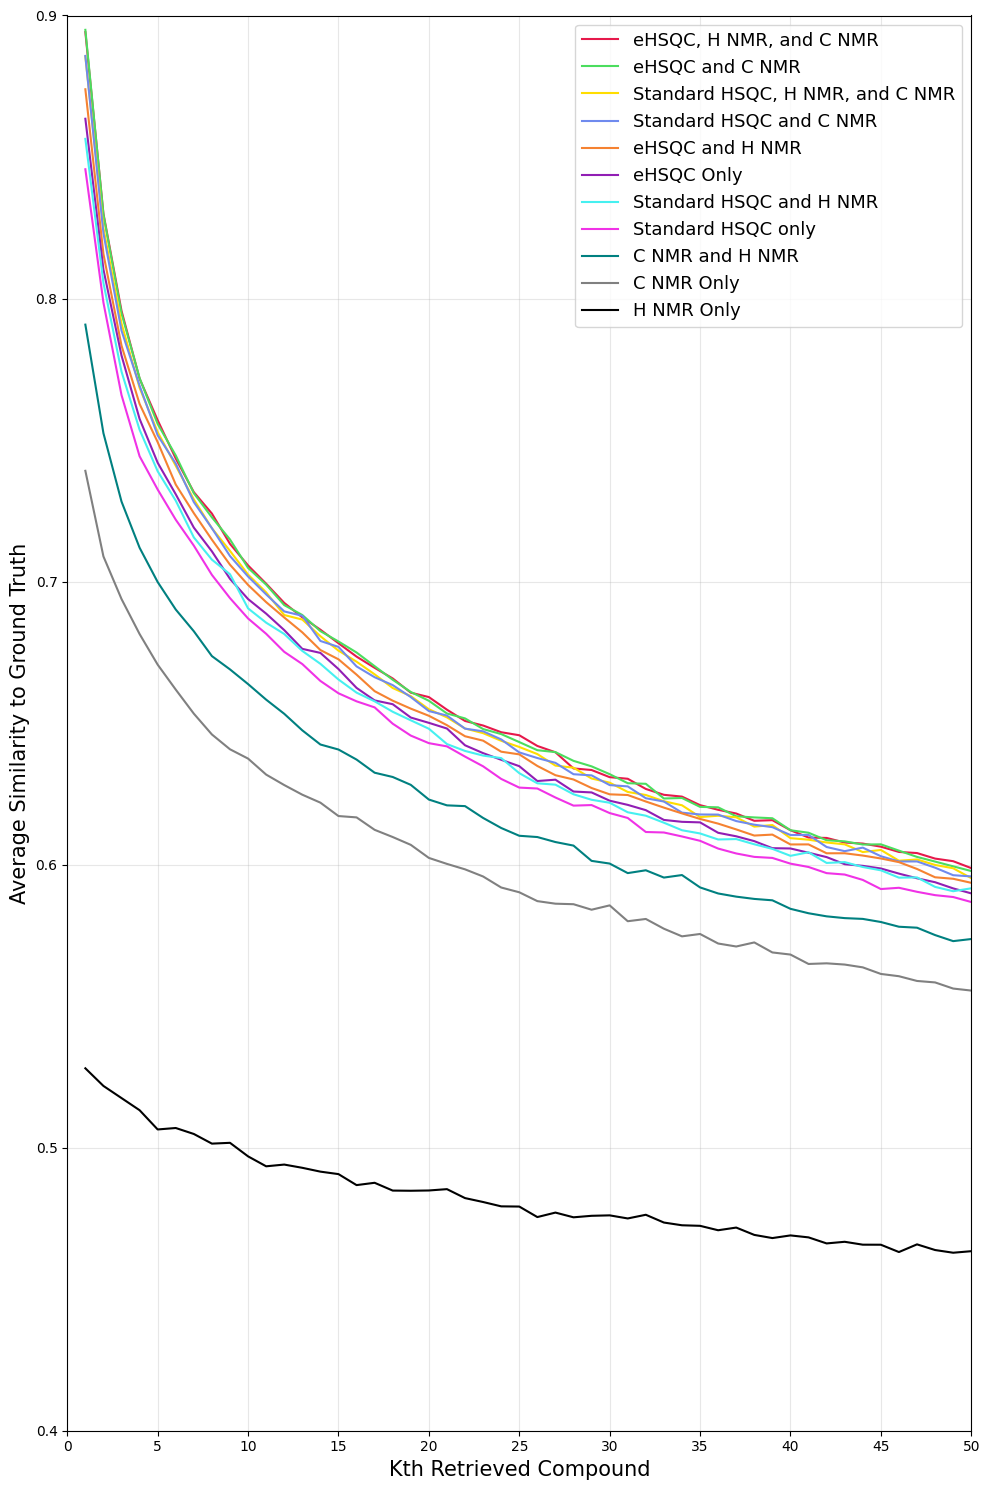

In [32]:
show_retrievals_similarity(all_sim_records,  title="")#Structure sim, using molecular weight

In [18]:
from collections import defaultdict

## without MW
all_sim_records_no_mw = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
        
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            
            # remove mw
            inputs = inputs[:, :-1]
            # remove mw
            NMR_type_indicator = NMR_type_indicator[:-1]
            
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=50)
        retrieval_sims=[]
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            retrieval_sims.append(cos_sim_of_smiles(retrieval_smile, ground_smiles[0]))

        all_sim_records_no_mw[loader_idx_to_name_mapping[i]].append(retrieval_sims)
        
        

  0%|          | 0/4056 [00:00<?, ?it/s]

 39%|███▉      | 1579/4056 [04:13<06:24,  6.44it/s][21:43:41] WARNING: not removing hydrogen atom without neighbors
[21:43:41] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:13<06:27,  6.39it/s][21:54:34] WARNING: not removing hydrogen atom without neighbors
[21:54:34] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:14<06:18,  6.55it/s][22:05:27] WARNING: not removing hydrogen atom without neighbors
[22:05:27] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:13<06:31,  6.33it/s][22:16:20] WARNING: not removing hydrogen atom without neighbors
[22:16:20] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:13<06:30,  6.35it/s][22:38:04] WARNING: not removing hydrogen atom without neighbors
[22:38:04] WARNING: not removing hydrogen atom without neighbors
 39%|███▉      | 1579/4056 [04:13<06:26,  6.41it/s][22:59:48] WARNING: not removing hydrogen at

In [19]:
# cobining DeepSAT result into mean_rank_records_no_MW
# import pickle
# import tqdm
# from collections import defaultdict
# mean_rank_records_no_mw = defaultdict(list)
shared_testset_pkl = "shared_testset_path_for_deepsat_hsqc_available" 
with open(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/{shared_testset_pkl}.pkl", "rb") as f:
    shared_testset_path = pickle.load(f)
    
    
deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set.pkl"
with open(deepsat_infer_results_save_path, "rb") as f:
    deepsat_infer_results = pickle.load(f)
    
all_sim_records_no_mw.update({"DeepSAT -- eHSQC": []})  
for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
    result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
    retrieval_sims=[]
    for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
        # if ( ground_smiles == filtered_smiles):
        
        retrieval_sims.append( cos_sim_of_smiles(filtered_smiles, ground_smiles))
    all_sim_records_no_mw["DeepSAT -- eHSQC"].append(retrieval_sims)
   
        
        
        
deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set_standard_HSQC.pkl"
with open(deepsat_infer_results_save_path, "rb") as f:
    deepsat_infer_results = pickle.load(f)
    
all_sim_records_no_mw.update({"DeepSAT -- Standard HSQC": []})  
for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
    result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
    retrieval_sims=[]
    for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
        # if ( ground_smiles == filtered_smiles):
        
        retrieval_sims.append( cos_sim_of_smiles(filtered_smiles, ground_smiles))
    all_sim_records_no_mw["DeepSAT -- Standard HSQC"].append(retrieval_sims)
    
    


100%|██████████| 341/341 [00:51<00:00,  6.67it/s]


np.float64(0.0)

In [20]:
all_sim_records_no_mw["DeepSAT -- eHSQC"]

[[1.0,
  0.9428090453147888,
  0.9128709435462952,
  0.8720665574073792,
  0.922531247138977,
  0.8856149315834045,
  0.8000000715255737,
  0.8687444925308228,
  0.843924880027771,
  0.8687444925308228,
  0.8856149315834045,
  0.8770579695701599,
  0.8944272398948669,
  0.8770579695701599,
  0.8253072500228882,
  0.8606629967689514,
  0.8687444925308228,
  0.8606629967689514,
  0.8687444925308228,
  0.8687444925308228,
  0.8528029322624207,
  0.8606629967689514,
  0.8770579695701599,
  0.8528029322624207,
  0.8606629967689514,
  0.8528029322624207,
  0.7380249500274658,
  0.8377078175544739,
  0.8164965510368347,
  0.8451542258262634,
  0.8164965510368347,
  0.8304547667503357,
  0.8032193779945374,
  0.7155417799949646,
  0.8032193779945374,
  0.8233869671821594,
  0.8032193779945374,
  0.7968190312385559,
  0.8233869671821594,
  0.7888426780700684,
  0.7171371579170227,
  0.7968190312385559,
  0.7287986278533936,
  0.6822423338890076,
  0.7228974103927612,
  0.6998789310455322,
  0.7

In [4]:
all_sim_records_no_mw.pop("DeepSAT -- Standard HSQC")
all_sim_records_no_mw.pop("DeepSAT -- eHSQC")

[[1.0,
  0.9428090453147888,
  0.9128709435462952,
  0.8720665574073792,
  0.922531247138977,
  0.8856149315834045,
  0.8000000715255737,
  0.8687444925308228,
  0.843924880027771,
  0.8687444925308228,
  0.8856149315834045,
  0.8770579695701599,
  0.8944272398948669,
  0.8770579695701599,
  0.8253072500228882,
  0.8606629967689514,
  0.8687444925308228,
  0.8606629967689514,
  0.8687444925308228,
  0.8687444925308228,
  0.8528029322624207,
  0.8606629967689514,
  0.8770579695701599,
  0.8528029322624207,
  0.8606629967689514,
  0.8528029322624207,
  0.7380249500274658,
  0.8377078175544739,
  0.8164965510368347,
  0.8451542258262634,
  0.8164965510368347,
  0.8304547667503357,
  0.8032193779945374,
  0.7155417799949646,
  0.8032193779945374,
  0.8233869671821594,
  0.8032193779945374,
  0.7968190312385559,
  0.8233869671821594,
  0.7888426780700684,
  0.7171371579170227,
  0.7968190312385559,
  0.7287986278533936,
  0.6822423338890076,
  0.7228974103927612,
  0.6998789310455322,
  0.7

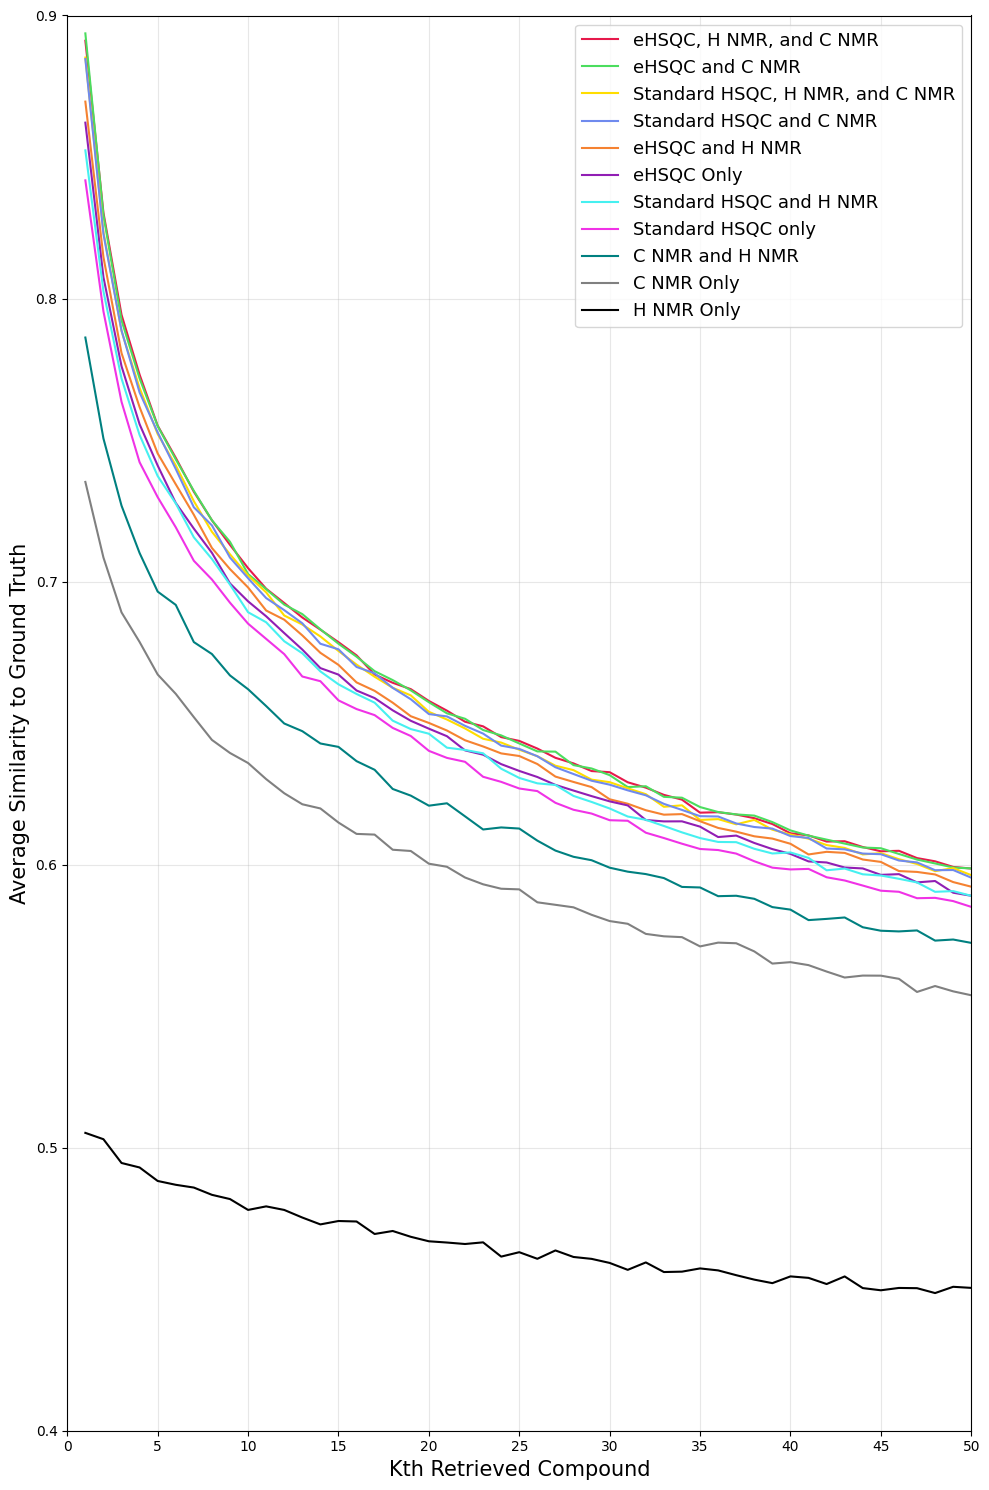

In [5]:
show_retrievals_similarity(all_sim_records_no_mw, title="") #Structure Annotation, not using molecular weight

In [23]:
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_similarity_with_mw.pkl", 'wb') as file:
    pickle.dump(all_sim_records, file)
with open(save_dir + "topk_similarity_without_mw.pkl", 'wb') as file:
    pickle.dump(all_sim_records_no_mw, file)
   

In [2]:
import pickle
save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_similarity_with_mw.pkl", 'rb') as file:
    all_sim_records = pickle.load(file)
with open(save_dir + "topk_similarity_without_mw.pkl", 'rb') as file:
    all_sim_records_no_mw = pickle.load(file)